# Detecção de Falhas em Motores de Indução - Análise de Séries Temporais Multivariadas

## 1. Introdução e Objetivo
Este projeto visa desenvolver um sistema de detecção de falhas mecânicas em motores de indução utilizando dados de séries temporais multivariadas capturadas por sensores no simulador de falhas mecânicas MFS (Machinery Fault Simulator). Vamos classificar diferentes tipos de falhas através de algoritmos de aprendizado de máquina.

## 2. Configuração e Importação de Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 3. Download e Carregamento do Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uysalserkan/fault-induction-motor-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fault-induction-motor-dataset' dataset.
Path to dataset files: /kaggle/input/fault-induction-motor-dataset


In [4]:
def data_loader(file_paths):
    """
    Carrega múltiplos arquivos CSV e concatena em um único DataFrame.
    """
    if len(file_paths) == 0:
        return pd.DataFrame()

    dataframes = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, header=None)
            dataframes.append(df)
        except Exception as e:
            print(f"Erro ao carregar {file_path}: {e}")

    return pd.concat(dataframes, ignore_index=True)


## 4. Carregamento e Exploração dos Dados

In [5]:
def data_loader(file_paths):
    """
    Carrega múltiplos arquivos CSV e concatena em um único DataFrame.
    """
    if not file_paths:
        return pd.DataFrame()

    dataframes = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, header=None)
            dataframes.append(df)
        except Exception as e:
            print(f"Erro ao carregar {file_path}: {e}")

    return pd.concat(dataframes, ignore_index=True)


In [6]:
paths = {
    "normal": os.path.join(path, "normal", "normal", "*.csv"),

    "imbalance_6g": os.path.join(path, "imbalance", "imbalance", "6g", "*.csv"),
    "imbalance_10g": os.path.join(path, "imbalance", "imbalance", "10g", "*.csv"),
    "imbalance_15g": os.path.join(path, "imbalance", "imbalance", "15g", "*.csv"),
    "imbalance_20g": os.path.join(path, "imbalance", "imbalance", "20g", "*.csv"),
    "imbalance_25g": os.path.join(path, "imbalance", "imbalance", "25g", "*.csv"),
    "imbalance_30g": os.path.join(path, "imbalance", "imbalance", "30g", "*.csv"),
    "imbalance_35g": os.path.join(path, "imbalance", "imbalance", "35g", "*.csv"),
}


In [7]:
datasets = {}

for label, pattern in paths.items():
    print(f"Carregando {label}...")
    files = glob.glob(pattern)
    datasets[label] = data_loader(files)


Carregando normal...
Carregando imbalance_6g...
Carregando imbalance_10g...
Carregando imbalance_15g...
Carregando imbalance_20g...
Carregando imbalance_25g...
Carregando imbalance_30g...
Carregando imbalance_35g...


In [8]:
print("\n=== Informações dos Datasets ===")
for label, df in datasets.items():
    print(f"{label}: {df.shape}")

    if df.empty:
        raise ValueError(
            f"Nenhum dado carregado para '{label}'. Verifique os paths."
        )



=== Informações dos Datasets ===
normal: (12250000, 8)
imbalance_6g: (12250000, 8)
imbalance_10g: (12000000, 8)
imbalance_15g: (12000000, 8)
imbalance_20g: (12250000, 8)
imbalance_25g: (11750000, 8)
imbalance_30g: (11750000, 8)
imbalance_35g: (11250000, 8)


## 5. Análise Exploratória de Dados

In [11]:
data_normal = datasets["normal"].copy()

# Nomeando colunas
n_sensors = data_normal.shape[1]
sensor_cols = [f"sensor_{i}" for i in range(n_sensors)]
data_normal.columns = sensor_cols


In [12]:
print("Primeiras 5 linhas do dataset NORMAL:")
display(data_normal.head())

print("\nInformações do dataset NORMAL:")
data_normal.info()


Primeiras 5 linhas do dataset NORMAL:


,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7
0,-0.79198,-0.32398,-0.45381,0.233640,-0.40261,-0.020101,-0.104640,-0.099248
1,-0.95877,0.70368,-0.28989,0.258740,-0.36562,-0.018753,-0.004520,0.038236
2,-0.80153,-0.07864,-0.46325,-0.012234,-0.46396,-0.022398,-0.043919,0.125900
3,-0.82726,0.67367,0.10146,-0.136560,-0.38256,-0.021468,0.049500,-0.160140
4,-0.95506,-0.10650,-0.48576,-0.470790,-0.49939,-0.024554,-0.024306,0.315180



Informações do dataset NORMAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250000 entries, 0 to 12249999
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   sensor_0  float64
 1   sensor_1  float64
 2   sensor_2  float64
 3   sensor_3  float64
 4   sensor_4  float64
 5   sensor_5  float64
 6   sensor_6  float64
 7   sensor_7  float64
dtypes: float64(8)
memory usage: 747.7 MB


In [13]:
print("\nEstatísticas descritivas – Operação Normal:")
display(
    data_normal.describe().T
)



Estatísticas descritivas – Operação Normal:


,count,mean,std,min,25%,50%,75%,max
sensor_0,12250000.0,0.000157,1.711226,-1.55880,-0.713510,-0.649150,-0.538410,5.10780
sensor_1,12250000.0,0.007892,0.853663,-4.48350,-0.559000,0.073510,0.652130,2.36720
sensor_2,12250000.0,-0.000466,0.417445,-3.41700,-0.286690,0.013319,0.297990,4.09980
sensor_3,12250000.0,0.000373,0.183769,-2.17170,-0.086501,0.000843,0.085292,1.93300
sensor_4,12250000.0,0.014837,0.624893,-2.95660,-0.330200,0.021706,0.346530,3.50870
sensor_5,12250000.0,0.003021,0.034798,-0.37335,-0.021577,0.004061,0.028108,0.28128
sensor_6,12250000.0,0.018774,0.413359,-2.86580,-0.229540,0.012973,0.261780,2.83600
sensor_7,12250000.0,0.012278,0.175592,-3.36910,-0.124540,-0.006497,0.133200,0.85290


In [14]:
print("\nTotal de valores nulos:")
print(data_normal.isnull().sum().sum())



Total de valores nulos:
0


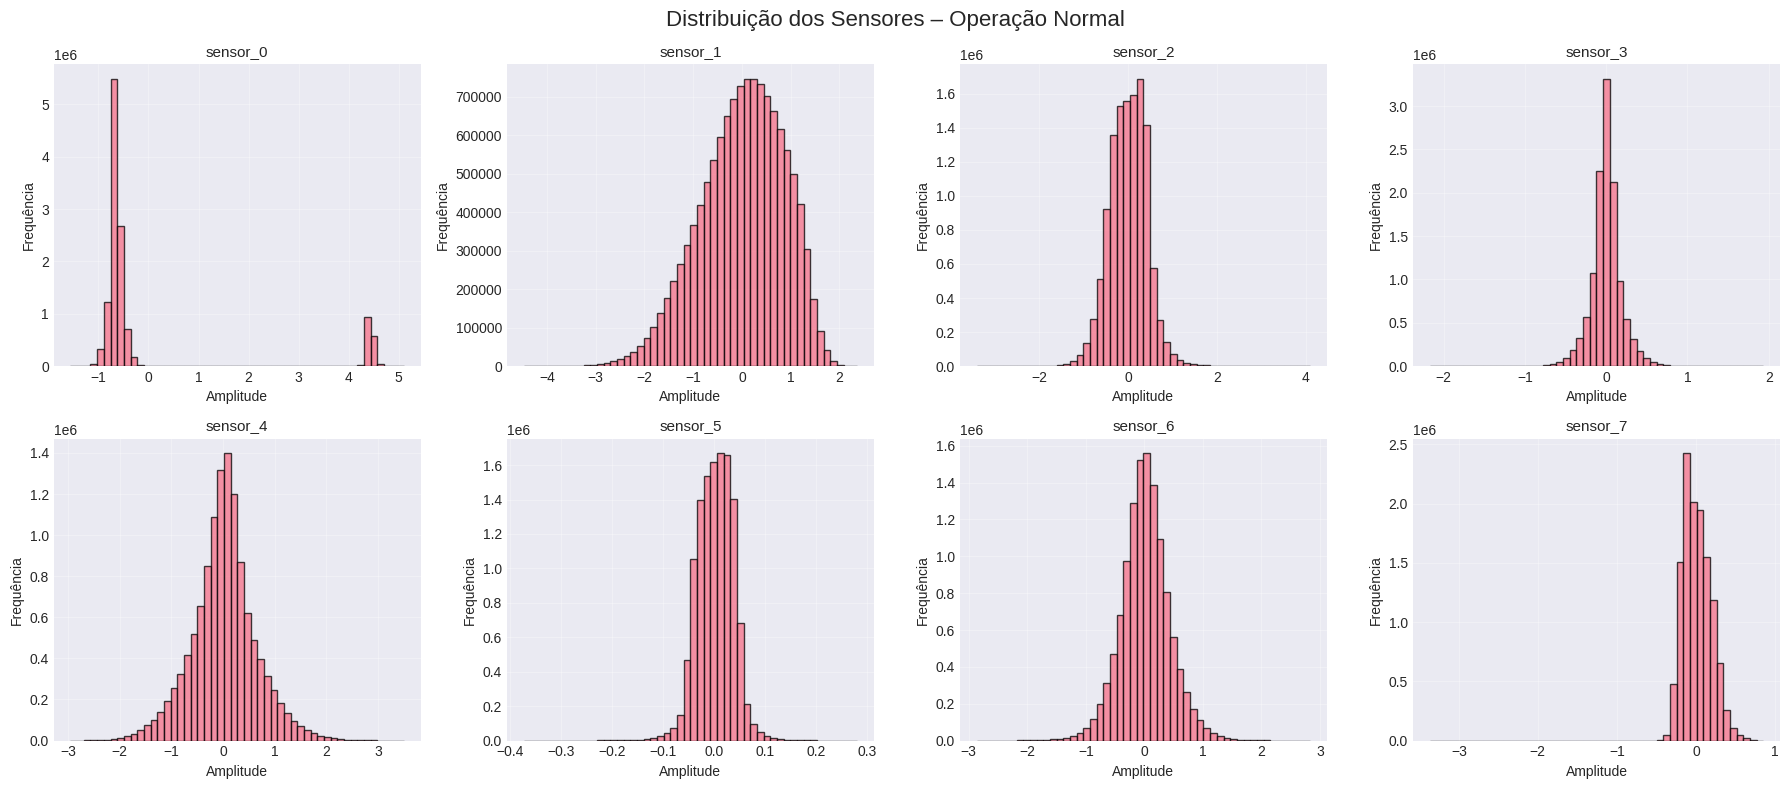

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    axes[i].hist(
        data_normal[col],
        bins=50,
        alpha=0.75,
        edgecolor="black"
    )
    axes[i].set_title(f"{col}", fontsize=11)
    axes[i].set_xlabel("Amplitude")
    axes[i].set_ylabel("Frequência")
    axes[i].grid(alpha=0.3)

plt.suptitle(
    "Distribuição dos Sensores – Operação Normal",
    fontsize=16
)
plt.tight_layout()
plt.show()


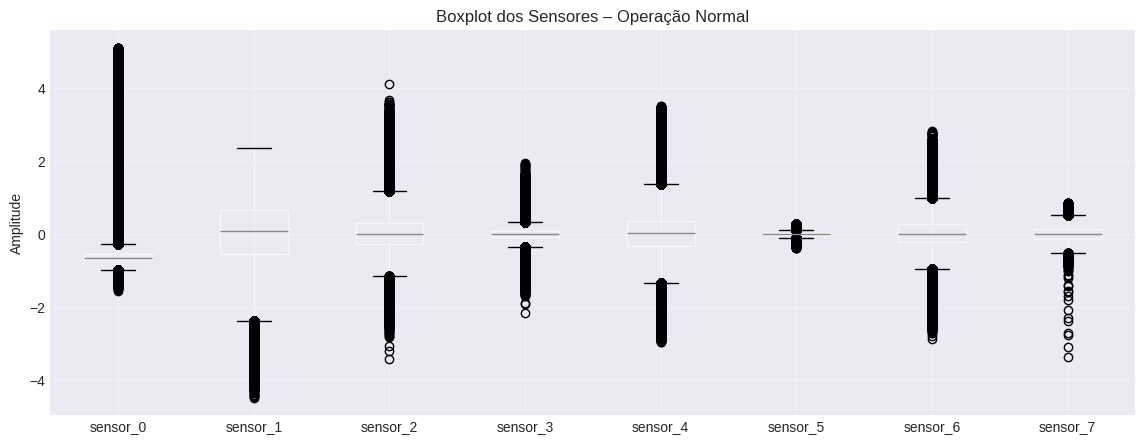

In [16]:
plt.figure(figsize=(14,5))
data_normal.boxplot()
plt.title("Boxplot dos Sensores – Operação Normal")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.show()


## 6. Pré-processamento dos Dados

### 6.1. Downsampling (Redução de Amostragem)

In [18]:
def downsampler(df, window_size=5000):
    """
    Reduz a dimensionalidade do sinal aplicando agregação por média
    em janelas temporais fixas.

    Args:
        df (pd.DataFrame): Dados dos sensores (somente colunas numéricas)
        window_size (int): Número de amostras por janela

    Returns:
        pd.DataFrame: Sinal reduzido (uma linha por janela)
    """
    numeric_df = df.select_dtypes(include="number")

    downsampled_rows = []
    n_samples = len(numeric_df)

    for start in range(0, n_samples, window_size):
        end = min(start + window_size, n_samples)
        window_mean = numeric_df.iloc[start:end].mean()
        downsampled_rows.append(window_mean)

    return pd.DataFrame(downsampled_rows)


In [19]:
print("Aplicando downsampling...")

downsampled_dfs = []

for label, df in datasets.items():
    df = df.copy()
    df.columns = sensor_cols

    df_down = downsampler(df, window_size=5000)
    df_down["fault_type"] = label

    downsampled_dfs.append(df_down)

data_down = pd.concat(downsampled_dfs, ignore_index=True)

print("Shape após downsampling:", data_down.shape)
data_down.head()


Aplicando downsampling...
Shape após downsampling: (19100, 9)


,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,fault_type
0,0.068100,0.011065,0.017430,0.001620,-0.059850,0.000868,-0.088720,0.010209,normal
1,-0.045139,0.015286,-0.010404,-0.000644,0.426827,0.005168,0.155058,0.013550,normal
2,-0.064635,0.029477,0.002314,0.001339,0.232491,0.005660,0.390845,0.009958,normal
3,0.089400,-0.002910,0.002770,-0.002331,-0.116512,-0.003224,0.219854,0.012501,normal
4,-0.070240,0.008164,-0.012449,0.002579,0.367824,0.008202,0.343822,0.010695,normal


In [20]:
print("Antes do downsampling:")
for k, v in datasets.items():
    print(f"{k}: {v.shape}")

print("\nDepois do downsampling:")
print(data_down["fault_type"].value_counts())


Antes do downsampling:
normal: (12250000, 8)
imbalance_6g: (12250000, 8)
imbalance_10g: (12000000, 8)
imbalance_15g: (12000000, 8)
imbalance_20g: (12250000, 8)
imbalance_25g: (11750000, 8)
imbalance_30g: (11750000, 8)
imbalance_35g: (11250000, 8)

Depois do downsampling:
fault_type
normal           2450
imbalance_6g     2450
imbalance_20g    2450
imbalance_10g    2400
imbalance_15g    2400
imbalance_25g    2350
imbalance_30g    2350
imbalance_35g    2250
Name: count, dtype: int64


Para reduzir a dimensionalidade e o custo computacional, foi aplicado um downsampling temporal utilizando agregação por média em janelas fixas. Essa abordagem preserva o comportamento estatístico global do sinal, ao mesmo tempo em que reduz redundâncias temporais comuns em sinais de alta frequência, sendo adequada para modelos supervisionados baseados em features agregadas.

### 6.2. Extração de Características no Domínio do Tempo

In [21]:
def extract_time_domain_features(df):
    """
    Extrai características estatísticas no domínio do tempo
    para cada janela temporal.

    Args:
        df (pd.DataFrame): Dados downsampled (linhas = janelas)

    Returns:
        pd.DataFrame: Vetores de features (uma linha por janela)
    """
    feature_rows = []

    for _, row in df.iterrows():
        features = {}

        for col in df.columns:
            signal_val = row[col]

            # Como o downsampling é por média,
            # usamos estatísticas entre sensores
            features[f"{col}_mean"] = signal_val
            features[f"{col}_abs"] = np.abs(signal_val)

        feature_rows.append(features)

    return pd.DataFrame(feature_rows)


In [22]:
def extract_time_domain_features(df, window_size=5000):
    """
    Extrai características estatísticas no domínio do tempo
    a partir de janelas temporais do sinal bruto.

    Returns:
        pd.DataFrame: Uma linha por janela (amostra)
    """
    feature_rows = []
    n_samples = len(df)

    for start in range(0, n_samples, window_size):
        end = min(start + window_size, n_samples)
        window = df.iloc[start:end]

        features = {}

        for col in window.columns:
            signal = window[col].values

            mean_val = np.mean(signal)
            std_val = np.std(signal)
            rms_val = np.sqrt(np.mean(signal**2))
            peak_val = np.max(np.abs(signal))
            skew_val = pd.Series(signal).skew()
            kurt_val = pd.Series(signal).kurtosis()

            crest_factor = peak_val / rms_val if rms_val != 0 else 0
            shape_factor = rms_val / np.mean(np.abs(signal)) if np.mean(np.abs(signal)) != 0 else 0

            features[f"{col}_mean"] = mean_val
            features[f"{col}_std"] = std_val
            features[f"{col}_rms"] = rms_val
            features[f"{col}_peak"] = peak_val
            features[f"{col}_skew"] = skew_val
            features[f"{col}_kurt"] = kurt_val
            features[f"{col}_crest"] = crest_factor
            features[f"{col}_shape"] = shape_factor

        feature_rows.append(features)

    return pd.DataFrame(feature_rows)


In [23]:
print("Extraindo features no domínio do tempo...")

feature_dfs = []

for label, df in datasets.items():
    df = df.copy()
    df.columns = sensor_cols

    feat_df = extract_time_domain_features(df, window_size=5000)
    feat_df["fault_type"] = label

    feature_dfs.append(feat_df)

features_data = pd.concat(feature_dfs, ignore_index=True)

print("Shape final do dataset de features:", features_data.shape)
features_data.head()


Extraindo features no domínio do tempo...
Shape final do dataset de features: (19100, 65)


,sensor_0_mean,sensor_0_std,sensor_0_rms,sensor_0_peak,sensor_0_skew,sensor_0_kurt,sensor_0_crest,sensor_0_shape,sensor_1_mean,sensor_1_std,...,sensor_6_shape,sensor_7_mean,sensor_7_std,sensor_7_rms,sensor_7_peak,sensor_7_skew,sensor_7_kurt,sensor_7_crest,sensor_7_shape,fault_type
0,0.068100,1.820665,1.821938,4.9240,1.951106,1.839167,2.702616,1.457121,0.011065,0.672650,...,1.246359,0.010209,0.198956,0.199218,0.73897,0.446653,-0.431100,3.709356,1.198621,normal
1,-0.045139,1.692641,1.693243,4.7841,2.233420,3.028976,2.825407,1.463880,0.015286,0.689724,...,1.260798,0.013550,0.203604,0.204054,0.77139,0.471393,-0.324640,3.780323,1.203168,normal
2,-0.064635,1.673501,1.674748,4.8088,2.280672,3.242746,2.871357,1.461685,0.029477,0.709197,...,1.209659,0.009958,0.198885,0.199134,0.79064,0.488042,-0.307529,3.970390,1.205978,normal
3,0.089400,1.839764,1.841935,4.8289,1.906948,1.663687,2.621646,1.456697,-0.002910,0.743219,...,1.271937,0.012501,0.203987,0.204370,0.74625,0.486978,-0.360118,3.651471,1.205195,normal
4,-0.070240,1.674898,1.676370,4.7738,2.280308,3.242214,2.847700,1.456677,0.008164,0.707161,...,1.246380,0.010695,0.200342,0.200628,0.77740,0.478527,-0.327533,3.874841,1.199428,normal


As características no domínio do tempo foram extraídas diretamente do sinal bruto utilizando janelas temporais fixas. Para cada janela, foram calculadas métricas estatísticas clássicas como RMS, curtose, assimetria e fator de crista, amplamente utilizadas em diagnóstico de falhas mecânicas. Essa abordagem preserva informações relevantes do comportamento dinâmico do sistema, evitando perda de informação causada por agregações prematuras.

### 6.3. Análise no Domínio da Frequência (FFT)

In [24]:
def extract_frequency_features(df, window_size=5000, fs=1000):
    """
    Extrai características no domínio da frequência a partir de janelas temporais
    do sinal bruto utilizando FFT.

    Args:
        df (pd.DataFrame): Sinal bruto (sensores nas colunas)
        window_size (int): Tamanho da janela temporal
        fs (int): Frequência de amostragem (Hz)

    Returns:
        pd.DataFrame: Vetores de features (uma linha por janela)
    """
    feature_rows = []
    n_samples = len(df)

    for start in range(0, n_samples, window_size):
        end = min(start + window_size, n_samples)
        window = df.iloc[start:end]

        features = {}

        for col in window.columns:
            signal = window[col].values
            n = len(signal)

            if n == 0:
                continue

            fft_vals = np.abs(np.fft.rfft(signal))
            freqs = np.fft.rfftfreq(n, d=1/fs)

            total_energy = np.sum(fft_vals**2)

            dominant_idx = np.argmax(fft_vals)
            dominant_freq = freqs[dominant_idx]
            dominant_mag = fft_vals[dominant_idx]

            low_energy = np.sum(fft_vals[freqs < fs*0.1]**2) / total_energy if total_energy > 0 else 0
            mid_energy = np.sum(fft_vals[(freqs >= fs*0.1) & (freqs < fs*0.3)]**2) / total_energy if total_energy > 0 else 0
            high_energy = np.sum(fft_vals[freqs >= fs*0.3]**2) / total_energy if total_energy > 0 else 0

            spectral_centroid = (
                np.sum(freqs * fft_vals) / np.sum(fft_vals)
                if np.sum(fft_vals) > 0 else 0
            )

            features[f"{col}_dom_freq"] = dominant_freq
            features[f"{col}_dom_mag"] = dominant_mag
            features[f"{col}_low_energy"] = low_energy
            features[f"{col}_mid_energy"] = mid_energy
            features[f"{col}_high_energy"] = high_energy
            features[f"{col}_spec_centroid"] = spectral_centroid

        feature_rows.append(features)

    return pd.DataFrame(feature_rows)


In [25]:
print("Extraindo características no domínio da frequência...")

freq_feature_dfs = []

for label, df in datasets.items():
    df = df.copy()
    df.columns = sensor_cols

    freq_df = extract_frequency_features(
        df,
        window_size=5000,
        fs=1000
    )

    freq_df["fault_type"] = label
    freq_feature_dfs.append(freq_df)

freq_features_data = pd.concat(freq_feature_dfs, ignore_index=True)

print("Shape do dataset de features de frequência:", freq_features_data.shape)
freq_features_data.head()


Extraindo características no domínio da frequência...
Shape do dataset de features de frequência: (19100, 49)


,sensor_0_dom_freq,sensor_0_dom_mag,sensor_0_low_energy,sensor_0_mid_energy,sensor_0_high_energy,sensor_0_spec_centroid,sensor_1_dom_freq,sensor_1_dom_mag,sensor_1_low_energy,sensor_1_mid_energy,...,sensor_6_mid_energy,sensor_6_high_energy,sensor_6_spec_centroid,sensor_7_dom_freq,sensor_7_dom_mag,sensor_7_low_energy,sensor_7_mid_energy,sensor_7_high_energy,sensor_7_spec_centroid,fault_type
0,1.8,3265.860962,0.993373,0.005288,0.001339,83.278113,440.4,1360.291465,0.586883,0.036903,...,0.011531,0.009329,84.030122,440.4,634.825542,0.054189,0.004576,0.941235,294.205269,normal
1,1.8,2806.561579,0.992273,0.006076,0.001651,85.731473,440.4,1382.793787,0.599632,0.030359,...,0.007729,0.006535,81.734382,440.4,649.023251,0.058293,0.004600,0.937106,291.762071,normal
2,1.8,2716.292143,0.993472,0.005086,0.001442,86.354272,440.4,1357.614095,0.631665,0.033172,...,0.003752,0.003260,76.102107,440.4,631.602113,0.056569,0.004623,0.938807,293.593388,normal
3,1.8,3351.837680,0.993462,0.005196,0.001342,86.655791,440.4,1381.136467,0.654387,0.028322,...,0.006981,0.005512,76.006925,440.4,647.896552,0.061174,0.004046,0.934780,292.793456,normal
4,1.8,2687.425871,0.993403,0.005063,0.001534,86.579266,440.4,1374.478013,0.621132,0.031473,...,0.005017,0.003852,79.060108,440.4,639.882957,0.057148,0.004017,0.938836,291.556548,normal


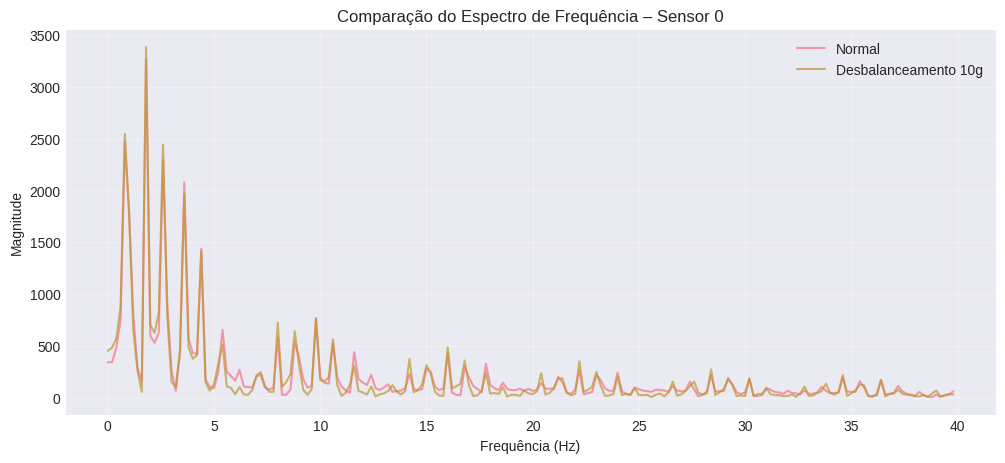

In [26]:
# Exemplo: janela do sinal bruto
signal_normal = datasets["normal"].iloc[:5000, 0].values
signal_imbalance = datasets["imbalance_10g"].iloc[:5000, 0].values

fs = 1000

fft_normal = np.abs(np.fft.rfft(signal_normal))
fft_imbalance = np.abs(np.fft.rfft(signal_imbalance))
freqs = np.fft.rfftfreq(len(signal_normal), d=1/fs)

plt.figure(figsize=(12,5))
plt.plot(freqs[:200], fft_normal[:200], label="Normal", alpha=0.7)
plt.plot(freqs[:200], fft_imbalance[:200], label="Desbalanceamento 10g", alpha=0.7)
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.title("Comparação do Espectro de Frequência – Sensor 0")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


As características no domínio da frequência foram extraídas a partir do sinal bruto utilizando a Transformada Rápida de Fourier (FFT) em janelas temporais fixas. Foram calculadas métricas como frequência dominante, centroides espectrais e distribuição de energia em bandas de frequência, amplamente utilizadas na identificação de falhas por desbalanceamento em sistemas rotativos, onde alterações espectrais são esperadas conforme o nível da falha aumenta.

## 7. Preparação do Dataset para Classificação

In [27]:
def combine_features(time_df, freq_df):
    """
    Combina características do tempo e frequência
    garantindo alinhamento correto das janelas.

    Returns:
        pd.DataFrame
    """
    time_df = time_df.reset_index(drop=True)
    freq_df = freq_df.reset_index(drop=True)

    assert len(time_df) == len(freq_df), "Desalinhamento entre features!"

    combined_df = pd.concat([time_df, freq_df], axis=1)
    return combined_df


In [29]:
print("Preparando dataset para classificação...")

feature_dfs = []

for label in features_data["fault_type"].unique(): # Corrected variable name
    time_df = features_data[ # Corrected variable name
        features_data["fault_type"] == label
    ].drop(columns="fault_type")

    freq_df = freq_features_data[
        freq_features_data["fault_type"] == label
    ].drop(columns="fault_type")

    combined_df = combine_features(time_df, freq_df)
    combined_df["fault_type"] = label

    feature_dfs.append(combined_df)

full_features = pd.concat(feature_dfs, ignore_index=True)

print("Shape final:", full_features.shape)
full_features.head()

Preparando dataset para classificação...
Shape final: (19100, 113)


,sensor_0_mean,sensor_0_std,sensor_0_rms,sensor_0_peak,sensor_0_skew,sensor_0_kurt,sensor_0_crest,sensor_0_shape,sensor_1_mean,sensor_1_std,...,sensor_6_mid_energy,sensor_6_high_energy,sensor_6_spec_centroid,sensor_7_dom_freq,sensor_7_dom_mag,sensor_7_low_energy,sensor_7_mid_energy,sensor_7_high_energy,sensor_7_spec_centroid,fault_type
0,0.068100,1.820665,1.821938,4.9240,1.951106,1.839167,2.702616,1.457121,0.011065,0.672650,...,0.011531,0.009329,84.030122,440.4,634.825542,0.054189,0.004576,0.941235,294.205269,normal
1,-0.045139,1.692641,1.693243,4.7841,2.233420,3.028976,2.825407,1.463880,0.015286,0.689724,...,0.007729,0.006535,81.734382,440.4,649.023251,0.058293,0.004600,0.937106,291.762071,normal
2,-0.064635,1.673501,1.674748,4.8088,2.280672,3.242746,2.871357,1.461685,0.029477,0.709197,...,0.003752,0.003260,76.102107,440.4,631.602113,0.056569,0.004623,0.938807,293.593388,normal
3,0.089400,1.839764,1.841935,4.8289,1.906948,1.663687,2.621646,1.456697,-0.002910,0.743219,...,0.006981,0.005512,76.006925,440.4,647.896552,0.061174,0.004046,0.934780,292.793456,normal
4,-0.070240,1.674898,1.676370,4.7738,2.280308,3.242214,2.847700,1.456677,0.008164,0.707161,...,0.005017,0.003852,79.060108,440.4,639.882957,0.057148,0.004017,0.938836,291.556548,normal


In [30]:
X = full_features.drop(columns="fault_type").values
y = full_features["fault_type"].values


In [31]:
print("Classes:", np.unique(y))
print("\nDistribuição das classes:")
print(pd.Series(y).value_counts(normalize=True) * 100)


Classes: ['imbalance_10g' 'imbalance_15g' 'imbalance_20g' 'imbalance_25g'
 'imbalance_30g' 'imbalance_35g' 'imbalance_6g' 'normal']

Distribuição das classes:
normal           12.827225
imbalance_6g     12.827225
imbalance_20g    12.827225
imbalance_10g    12.565445
imbalance_15g    12.565445
imbalance_25g    12.303665
imbalance_30g    12.303665
imbalance_35g    11.780105
Name: proportion, dtype: float64


## 8. Normalização dos Dados

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [33]:
print("Aplicando normalização (sem data leakage)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Aplicando normalização (sem data leakage)...


In [34]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

print("Classes codificadas:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {i}")


Classes codificadas:
  imbalance_10g: 0
  imbalance_15g: 1
  imbalance_20g: 2
  imbalance_25g: 3
  imbalance_30g: 4
  imbalance_35g: 5
  imbalance_6g: 6
  normal: 7


## 9. Divisão dos Dados

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treino: (13370, 112)
Tamanho do conjunto de teste: (5730, 112)


Mapeamento das classes:
  imbalance_10g: 0
  imbalance_15g: 1
  imbalance_20g: 2
  imbalance_25g: 3
  imbalance_30g: 4
  imbalance_35g: 5
  imbalance_6g: 6
  normal: 7


In [38]:
print("\nDistribuição das classes no treino:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for idx, count in zip(unique_train, counts_train):
    print(f"  Classe {idx} ({label_encoder.inverse_transform([idx])[0]}): {count} amostras")

print("\nDistribuição das classes no teste:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for idx, count in zip(unique_test, counts_test):
    print(f"  Classe {idx} ({label_encoder.inverse_transform([idx])[0]}): {count} amostras")



Distribuição das classes no treino:
  Classe 0 (imbalance_10g): 1680 amostras
  Classe 1 (imbalance_15g): 1680 amostras
  Classe 2 (imbalance_20g): 1715 amostras
  Classe 3 (imbalance_25g): 1645 amostras
  Classe 4 (imbalance_30g): 1645 amostras
  Classe 5 (imbalance_35g): 1575 amostras
  Classe 6 (imbalance_6g): 1715 amostras
  Classe 7 (normal): 1715 amostras

Distribuição das classes no teste:
  Classe 0 (imbalance_10g): 720 amostras
  Classe 1 (imbalance_15g): 720 amostras
  Classe 2 (imbalance_20g): 735 amostras
  Classe 3 (imbalance_25g): 705 amostras
  Classe 4 (imbalance_30g): 705 amostras
  Classe 5 (imbalance_35g): 675 amostras
  Classe 6 (imbalance_6g): 735 amostras
  Classe 7 (normal): 735 amostras


O conjunto de dados foi particionado em treino e teste de forma estratificada. A normalização foi aplicada exclusivamente com estatísticas estimadas no conjunto de treino, evitando vazamento de informação e garantindo uma avaliação justa do desempenho dos modelos de classificação.

## 10. Modelos de Classificação

### 10.1. Random Forest Classifier

In [39]:
print("=== Random Forest Classifier ===")

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)


=== Random Forest Classifier ===


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [40]:
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)


In [41]:
print("\nMétricas de Desempenho:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precisão (weighted): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")



Métricas de Desempenho:
Acurácia: 0.9988
Precisão (weighted): 0.9988
Recall (weighted): 0.9988
F1-score (weighted): 0.9988


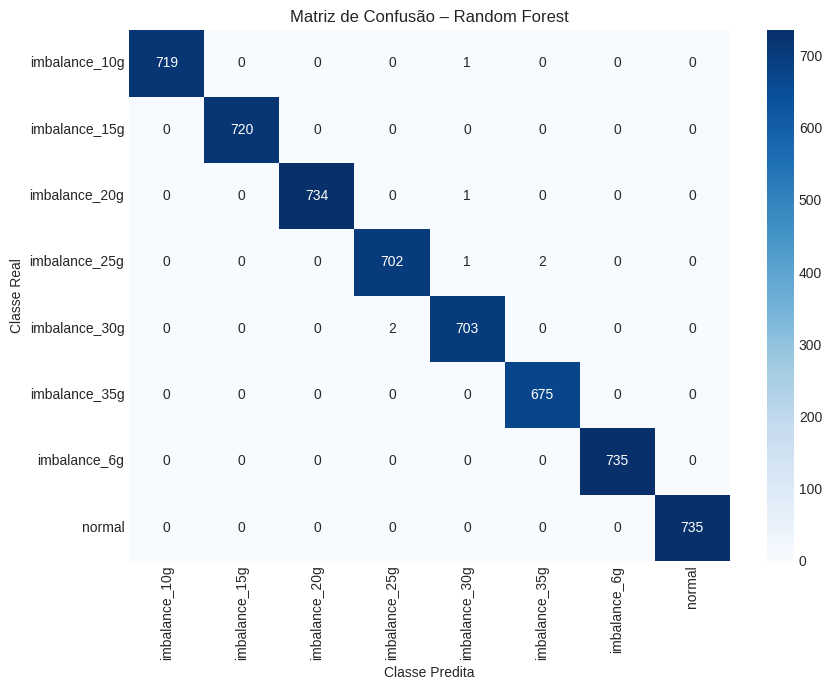

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(9, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title("Matriz de Confusão – Random Forest")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()


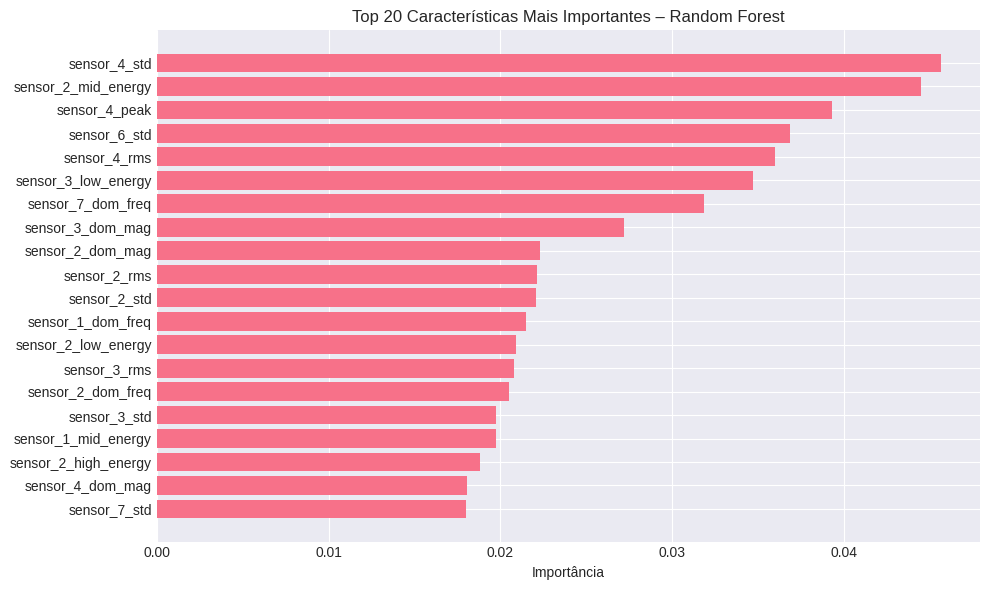

In [44]:
feature_names = full_features.drop(columns="fault_type").columns
importances = rf_model.feature_importances_

# Top 20
idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(idx)),
    importances[idx]
)
plt.yticks(range(len(idx)), feature_names[idx])
plt.xlabel("Importância")
plt.title("Top 20 Características Mais Importantes – Random Forest")
plt.tight_layout()
plt.show()


## 10.2. XGBoost Classifier

In [45]:
print("=== XGBoost Classifier ===")

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=len(np.unique(y_train)),
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss"
)

xgb_model.fit(X_train, y_train)


=== XGBoost Classifier ===


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=8, ...)

In [46]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)


In [47]:
print("\nMétricas de Desempenho:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precisão (weighted): {precision_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"F1-score (weighted): {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")



Métricas de Desempenho:
Acurácia: 0.9984
Precisão (weighted): 0.9984
Recall (weighted): 0.9984
F1-score (weighted): 0.9984


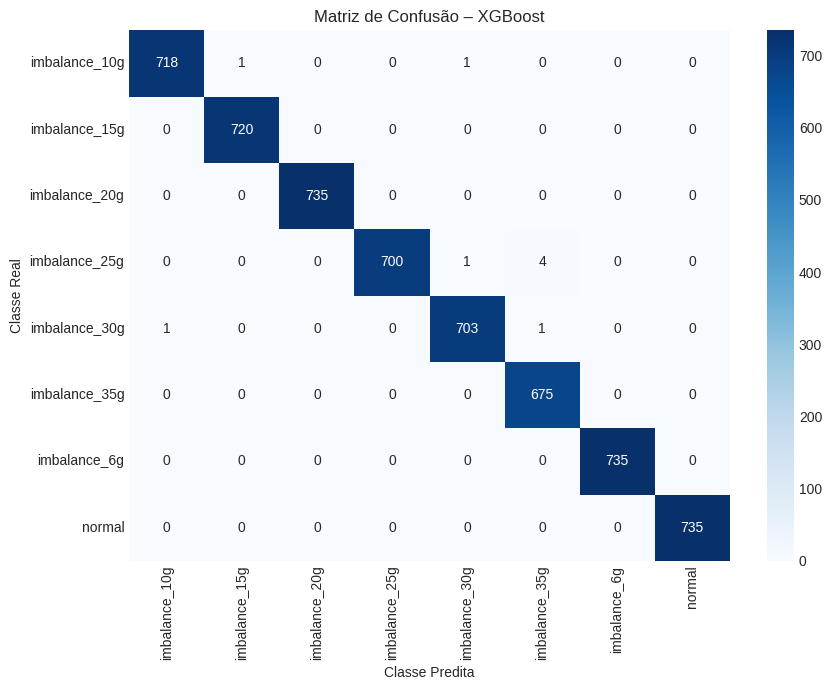

In [49]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(9, 7))
sns.heatmap(
    conf_matrix_xgb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title("Matriz de Confusão – XGBoost")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()


In [50]:
print("\nRelatório de Classificação Detalhado:")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=label_encoder.classes_
))



Relatório de Classificação Detalhado:
               precision    recall  f1-score   support

imbalance_10g       1.00      1.00      1.00       720
imbalance_15g       1.00      1.00      1.00       720
imbalance_20g       1.00      1.00      1.00       735
imbalance_25g       1.00      0.99      1.00       705
imbalance_30g       1.00      1.00      1.00       705
imbalance_35g       0.99      1.00      1.00       675
 imbalance_6g       1.00      1.00      1.00       735
       normal       1.00      1.00      1.00       735

     accuracy                           1.00      5730
    macro avg       1.00      1.00      1.00      5730
 weighted avg       1.00      1.00      1.00      5730



In [51]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [53]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(label_encoder.classes_), # Corrected: used label_encoder.classes_
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss"
    ))
])

In [55]:
print("=== Validação Cruzada (5-Fold) ===")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fix: Define y_encoded using the already fitted label_encoder
y_encoded = label_encoder.transform(y)

print("\nRandom Forest:")
rf_cv_scores = cross_val_score(
    rf_pipeline, X, y_encoded, cv=cv, scoring="accuracy"
)
print(f"Acurácia média: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

print("\nXGBoost:")
xgb_cv_scores = cross_val_score(
    xgb_pipeline, X, y_encoded, cv=cv, scoring="accuracy"
)
print(f"Acurácia média: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")

=== Validação Cruzada (5-Fold) ===

Random Forest:
Acurácia média: 0.9972 ± 0.0010

XGBoost:
Acurácia média: 0.9991 ± 0.0005


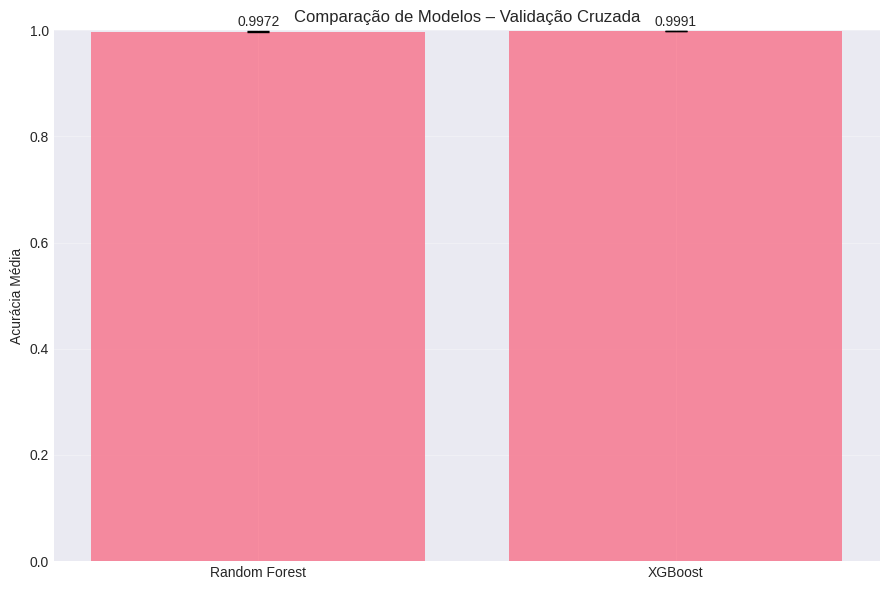

In [56]:
plt.figure(figsize=(9, 6))

models = ['Random Forest', 'XGBoost']
mean_scores = [rf_cv_scores.mean(), xgb_cv_scores.mean()]
std_scores = [rf_cv_scores.std(), xgb_cv_scores.std()]

bars = plt.bar(
    models,
    mean_scores,
    yerr=std_scores,
    capsize=8,
    alpha=0.8
)

plt.ylabel('Acurácia Média')
plt.title('Comparação de Modelos – Validação Cruzada')
plt.ylim(0, 1)

for bar, score in zip(bars, mean_scores):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f'{score:.4f}',
        ha='center'
    )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 12. Análise Comparativa dos Modelos

In [57]:
print("=== Análise Comparativa dos Modelos ===")

metrics = {
    'Random Forest': {
        'Accuracy (Teste)': accuracy_score(y_test, y_pred_rf),
        'Precision (Teste)': precision_score(y_test, y_pred_rf, average='weighted'),
        'Recall (Teste)': recall_score(y_test, y_pred_rf, average='weighted'),
        'F1-score (Teste)': f1_score(y_test, y_pred_rf, average='weighted'),
        'CV Accuracy (Média)': rf_cv_scores.mean(),
        'CV Accuracy (Std)': rf_cv_scores.std()
    },
    'XGBoost': {
        'Accuracy (Teste)': accuracy_score(y_test, y_pred_xgb),
        'Precision (Teste)': precision_score(y_test, y_pred_xgb, average='weighted'),
        'Recall (Teste)': recall_score(y_test, y_pred_xgb, average='weighted'),
        'F1-score (Teste)': f1_score(y_test, y_pred_xgb, average='weighted'),
        'CV Accuracy (Média)': xgb_cv_scores.mean(),
        'CV Accuracy (Std)': xgb_cv_scores.std()
    }
}

comparison_df = pd.DataFrame(metrics).T.round(4)

print("\nTabela Comparativa de Métricas:")
display(comparison_df)


=== Análise Comparativa dos Modelos ===

Tabela Comparativa de Métricas:


,Accuracy (Teste),Precision (Teste),Recall (Teste),F1-score (Teste),CV Accuracy (Média),CV Accuracy (Std)
Random Forest,0.9988,0.9988,0.9988,0.9988,0.9972,0.0010
XGBoost,0.9984,0.9984,0.9984,0.9984,0.9991,0.0005


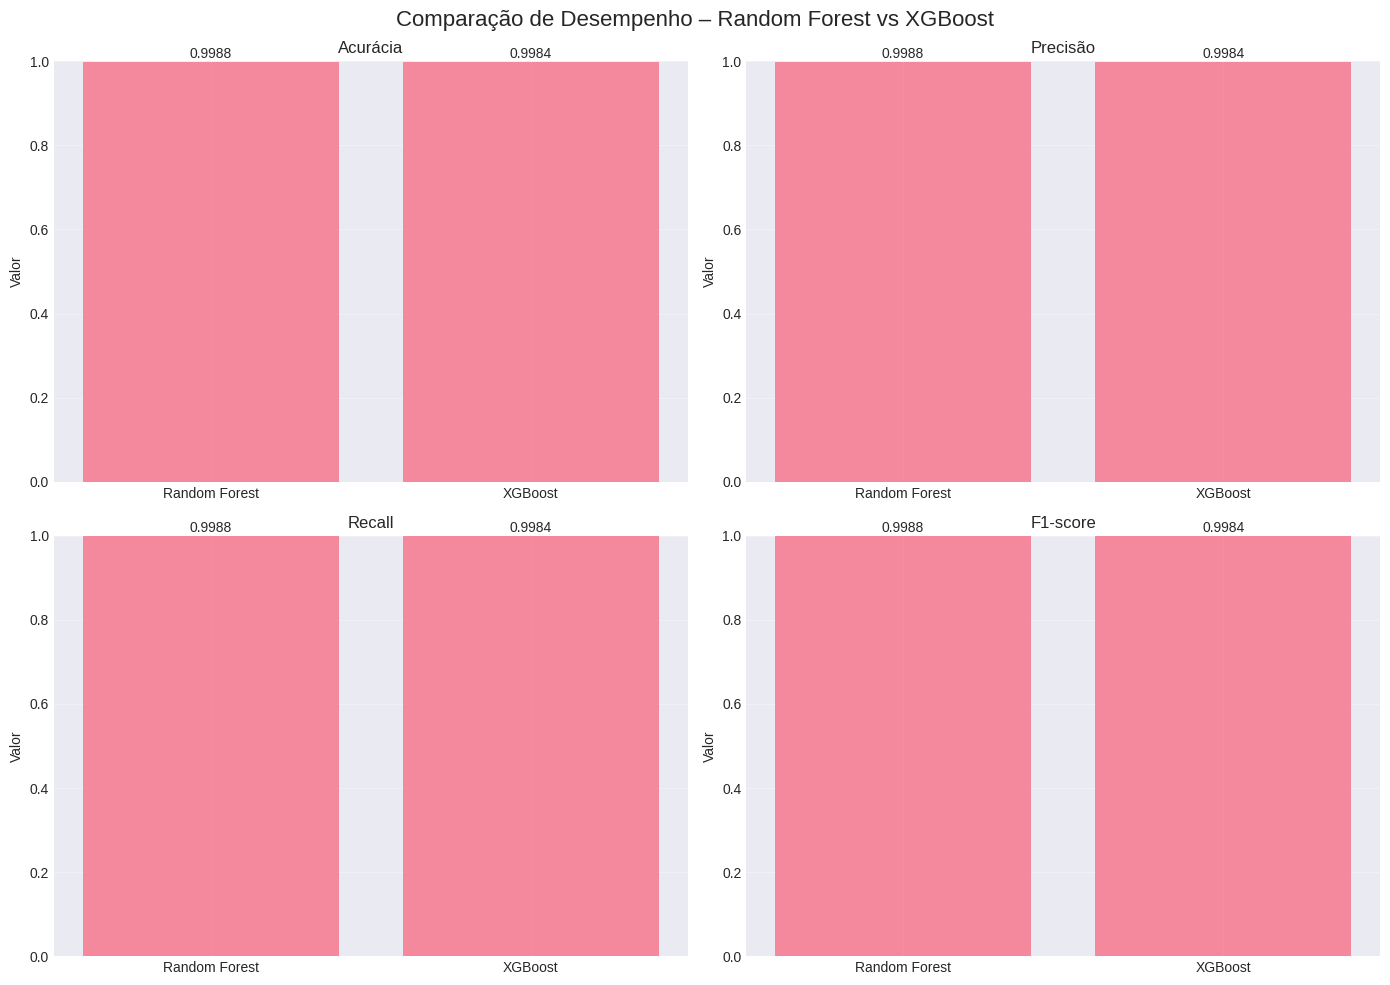

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metric_map = {
    'Accuracy (Teste)': 'Acurácia',
    'Precision (Teste)': 'Precisão',
    'Recall (Teste)': 'Recall',
    'F1-score (Teste)': 'F1-score'
}

for idx, (metric, title) in enumerate(metric_map.items()):
    rf_val = metrics['Random Forest'][metric]
    xgb_val = metrics['XGBoost'][metric]

    bars = axes[idx].bar(
        ['Random Forest', 'XGBoost'],
        [rf_val, xgb_val],
        alpha=0.8
    )

    axes[idx].set_title(title)
    axes[idx].set_ylabel('Valor')
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(axis='y', alpha=0.3)

    for bar, val in zip(bars, [rf_val, xgb_val]):
        axes[idx].text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f'{val:.4f}',
            ha='center'
        )

plt.suptitle('Comparação de Desempenho – Random Forest vs XGBoost', fontsize=16)
plt.tight_layout()
plt.show()


## 13. Análise de Erros e Discussão

In [59]:
print("=== Análise de Erros – XGBoost ===")

# Índices incorretos
incorrect_idx = np.where(y_pred_xgb != y_test)[0]
total_errors = len(incorrect_idx)

print(f"\nTotal de classificações incorretas: {total_errors}")
print(f"Taxa de erro: {total_errors / len(y_test) * 100:.2f}%")

# Erros por classe verdadeira
error_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred_xgb
})

error_df['true_label'] = label_encoder.inverse_transform(error_df['true'])
error_df['pred_label'] = label_encoder.inverse_transform(error_df['pred'])

misclassified = error_df[error_df['true'] != error_df['pred']]

print("\nErros por classe verdadeira (%):")
error_rate = (
    misclassified.groupby('true_label').size() /
    error_df.groupby('true_label').size()
).fillna(0) * 100

display(error_rate.round(2))


=== Análise de Erros – XGBoost ===

Total de classificações incorretas: 9
Taxa de erro: 0.16%

Erros por classe verdadeira (%):


,0
true_label,
imbalance_10g,0.28
imbalance_15g,0.00
imbalance_20g,0.00
imbalance_25g,0.71
imbalance_30g,0.28
imbalance_35g,0.00
imbalance_6g,0.00
normal,0.00


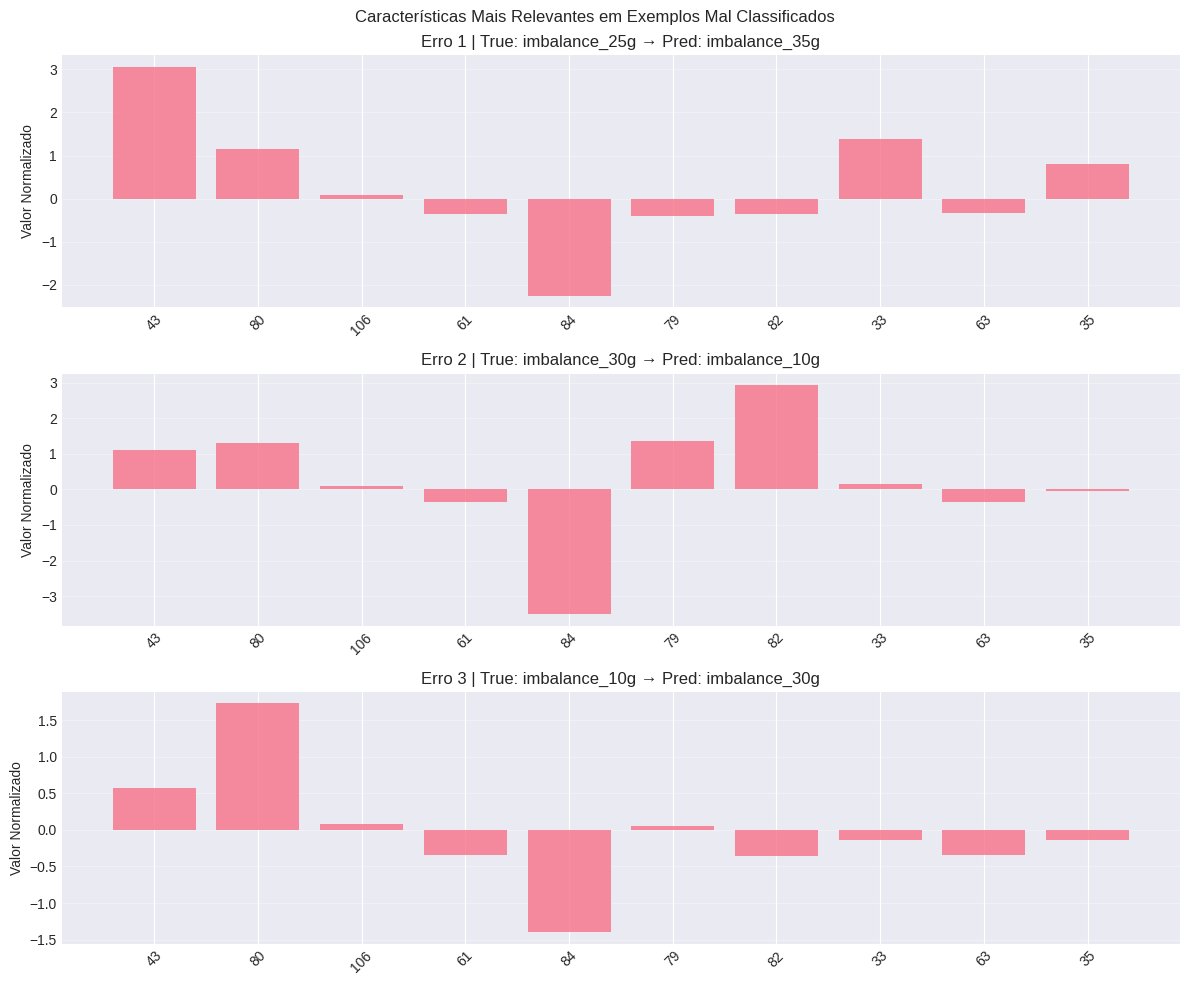

In [61]:
# Top features segundo XGBoost
feature_importance_xgb = xgb_model.feature_importances_
top_features = np.argsort(feature_importance_xgb)[-10:]

if total_errors >= 3:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    for i, idx in enumerate(incorrect_idx[:3]):
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred_xgb[idx]])[0]

        axes[i].bar(
            range(len(top_features)),
            X_test[idx, top_features],
            alpha=0.8
        )

        axes[i].set_title(
            f'Erro {i+1} | True: {true_label} → Pred: {pred_label}'
        )
        axes[i].set_xticks(range(len(top_features)))
        axes[i].set_xticklabels(top_features, rotation=45)
        axes[i].set_ylabel('Valor Normalizado')
        axes[i].grid(axis='y', alpha=0.3)

    plt.suptitle('Características Mais Relevantes em Exemplos Mal Classificados')
    plt.tight_layout()
    plt.show()


In [62]:
print("\n=== Análise de Overfitting ===")

models = {
    'Random Forest': (rf_model, rf_cv_scores),
    'XGBoost': (xgb_model, xgb_cv_scores)
}

for name, (model, cv_scores) in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    cv_mean = cv_scores.mean()

    print(f"\n{name}:")
    print(f"  Acurácia Treino: {train_acc:.4f}")
    print(f"  Acurácia Teste:  {test_acc:.4f}")
    print(f"  CV (5-fold):     {cv_mean:.4f}")

    if train_acc - cv_mean > 0.05:
        print("  ⚠️ Indício de overfitting")
    else:
        print("  ✓ Boa capacidade de generalização")



=== Análise de Overfitting ===

Random Forest:
  Acurácia Treino: 0.9998
  Acurácia Teste:  0.9988
  CV (5-fold):     0.9972
  ✓ Boa capacidade de generalização

XGBoost:
  Acurácia Treino: 1.0000
  Acurácia Teste:  0.9984
  CV (5-fold):     0.9991
  ✓ Boa capacidade de generalização
